In [1]:
import numpy as np
#import pylab as pl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.signal 
import sys

In [4]:
import cv2

In [5]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

image = mpimg.imread('images64/f0_b64.png')

n_channels = len(np.shape(image))

if(n_channels == 3):
    image=rgb2gray(image)

image *= 255.0
imrows, imcols = np.shape(image)

In [8]:
def im2col(A,BLKSZ):   

    # Parameters
    M,N = A.shape
    col_extent = N - BLKSZ[1] + 1
    row_extent = M - BLKSZ[0] + 1

    # Get Starting block indices
    start_idx = np.arange(BLKSZ[0])[:,None]*N + np.arange(BLKSZ[1])

    # Get offsetted indices across the height and width of input array
    offset_idx = np.arange(row_extent)[:,None]*N + np.arange(col_extent)

    # Get all actual indices & index into input array for final output
    return np.take (A,start_idx.ravel()[:,None] + offset_idx.ravel())

def coltfilt(A, size):
    original_shape = np.shape(A)
    a,b = 0, 0
    if(size%2==0):
        a, b = int(size/2)-1, int(size/2)
    else:
        a,b = int(size/2), int(size/2)
    A = np.lib.pad(A, (a, b), 'constant')
    Acol = im2col(A, (size, size))
    rc = np.floor((Acol.max(axis=0) - Acol.min(axis=0))/float(size)) + 1
    return np.reshape(rc, original_shape)
    
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def mat2gray(mat):
    maxI = np.max(mat)
    minI = np.min(mat)
    gray = (mat[:,:] - minI) / (maxI - minI)
    return gray


Calculating DBC image
Calculating FD image


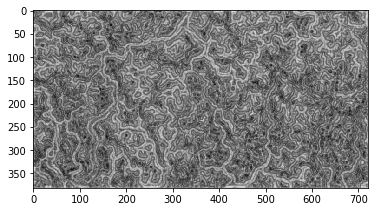

In [9]:
B = np.zeros((6, imrows, imcols))

print("Calculating Differential Box Counting image")

for r in range(2,8):
    mask = matlab_style_gauss2D((r,r), r/2.0)
    im = scipy.signal.convolve2d(image, mask, mode='same')
    F = (coltfilt(im, r))*(49/(r**2))
    B[r - 2] = np.log(F)
    
    
#------- computing the slope using linear regression -------

print("Calculating FD image")

i = np.log(range(2,8)) #Normalised scale range vector

Nxx = np.dot(i,i) - (np.sum(i)**2)/6
FD = np.zeros((imrows,imcols))

for m in range(1,imrows):
    for n in range(1,imcols):
        fd = [B[5,m,n], B[4,m,n], B[3,m,n], B[2,m,n], B[1,m,n], B[0,m,n]] #Number of boxes multiscale vector
        Nxy = np.dot(i,fd) - (sum(i)*sum(fd))/6
        FD[m,n] = Nxy/Nxx # slope of the linear regression line

tmp = np.zeros(np.shape(B))
for r in range(2,8):
    tmp[r-2, :, :] = FD * np.log(m)

intercept = np.mean(B - tmp, axis=0)

FDB = mat2gray(FD);

intercept_image = mat2gray(intercept)

#imgplot = plt.imshow(FDB)
plt.imshow(intercept_image, cmap='gray')
plt.show()